In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import sklearn.metrics as metrics

In [2]:
train = pd.read_csv("/kaggle/input/emnist/emnist-balanced-train.csv",delimiter = ',')
test = pd.read_csv("/kaggle/input/emnist/emnist-balanced-test.csv", delimiter = ',')
mapp = pd.read_csv("/kaggle/input/emnist/emnist-balanced-mapping.txt", delimiter = ' ', \
                   index_col=0, header=None)

In [3]:
train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]

test_x = test.iloc[:,1:]
test_y = test.iloc[:,0]

In [4]:
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(112799, 784) (112799,) (18799, 784) (18799,)


In [5]:
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [6]:
# Flip and rotate image
train_x = np.asarray(train_x)
train_x = np.apply_along_axis(rotate, 1, train_x)
print ("train_x:",train_x.shape)

test_x = np.asarray(test_x)
test_x = np.apply_along_axis(rotate, 1, test_x)
print ("test_x:",test_x.shape)

train_x: (112799, 28, 28)
test_x: (18799, 28, 28)


In [7]:
# Normalise
train_x = train_x.astype('float32')/255
test_x = test_x.astype('float32')/255

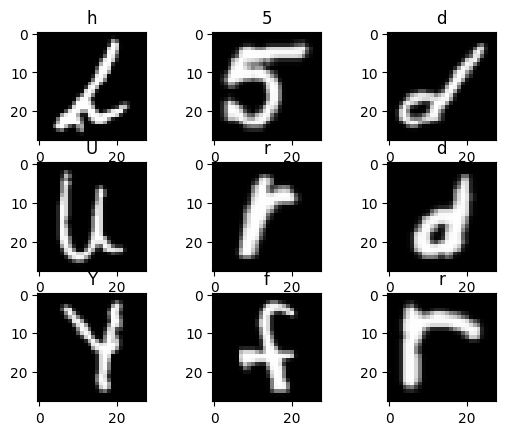

In [8]:
for i in range(100, 109):
    plt.subplot(330 + (i - 99))
    plt.imshow(train_x[i], cmap=plt.get_cmap('gray'))
    label = train_y.iloc[i]  # Retrieve label from train_y
    character = chr(mapp.loc[label].values[0])  # Get the character using .loc
    plt.title(character)

plt.show()

In [9]:
num_classes = train_y.nunique()
num_classes

47

In [10]:
# Define the number of classes based on the dataset
num_classes = len(mapp)  

# One-hot encode the labels
train_y = to_categorical(train_y, num_classes)
test_y = to_categorical(test_y, num_classes)

In [11]:
# Reshape image for CNN
train_x = train_x.reshape(-1, 28, 28, 1)
test_x = test_x.reshape(-1, 28, 28, 1)

# Train and Validation Split

In [12]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size= 0.10, random_state=7)

# Model Building


In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from keras.regularizers import l2

# Define the number of classes (adjust based on your EMNIST dataset subset)
number_of_classes = 47  # Update this based on your specific EMNIST subset (e.g., Balanced, Letters, Digits)

# Build the model
model = Sequential()

# First convolutional layer with BatchNormalization and LeakyReLU
model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1), kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Fully connected layers with BatchNormalization, LeakyReLU, and Dropout
model.add(Dense(512, kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))

model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(number_of_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 11, 11, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 3, 3, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 233,903 (913.68 KB)

 Trainable params: 232,175 (906.93 KB)

 Non-trainable params: 1,728 (6.75 KB)

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
history = model.fit(train_x, train_y, epochs=25, batch_size=512, verbose=1, \
                    validation_data=(val_x, val_y))

Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.3568 - loss: 13.5652 - val_accuracy: 0.0231 - val_loss: 5.7978
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7446 - loss: 2.1197 - val_accuracy: 0.0738 - val_loss: 4.3560
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7793 - loss: 1.2132 - val_accuracy: 0.4806 - val_loss: 2.1595
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7930 - loss: 1.0152 - val_accuracy: 0.6810 - val_loss: 1.3643
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7988 - loss: 0.9354 - val_accuracy: 0.7306 - val_loss: 1.1736
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8109 - loss: 0.8649 - val_accuracy: 0.7662 - val_loss: 0.9980
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8163 - loss: 0.8352 - val_accuracy: 0.8103 - val_loss: 0.8248
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8182 - loss: 0.8189 - val_accuracy:

Plotting Accuracy and Loss


In [19]:
def plot_graph(epochs, train_metric, val_metric, title, ylabel):
    plt.plot(epochs, train_metric, 'b', label='Train')
    plt.plot(epochs, val_metric, 'r', label='Validation')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

# Extract metrics from history
acc = history.history['accuracy'] if 'accuracy' in history.history else history.history['acc']
val_acc = history.history['val_accuracy'] if 'val_accuracy' in history.history else history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

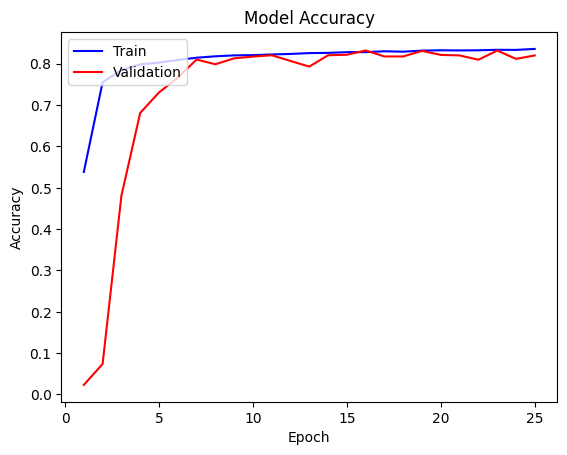

In [20]:
plot_graph(epochs, acc, val_acc, 'Model Accuracy', 'Accuracy')

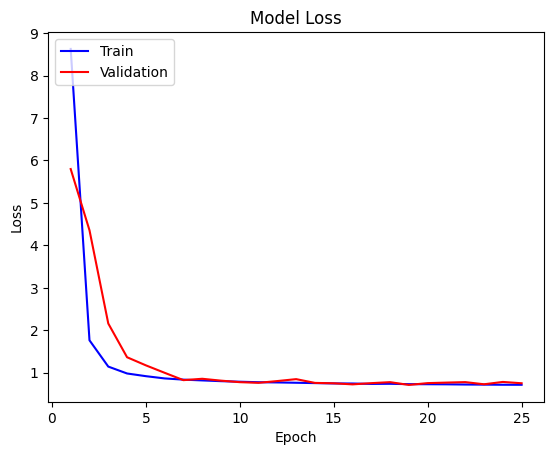

In [21]:
plot_graph(epochs, loss, val_loss, 'Model Loss', 'Loss')

# Predicting the test data


In [22]:
test_acc = model.evaluate(test_x, test_y)
print('Loss value is ',test_acc[0])
print('Accuracy value is ',test_acc[1])

588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8212 - loss: 0.7570
Loss value is  0.7605925798416138
Accuracy value is  0.8212670683860779


In [23]:
#Prediction
y_pred_test = model.predict(test_x)
# Finding shape
y_pred_test.shape

588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


(18799, 47)

Visualizing some predicted values

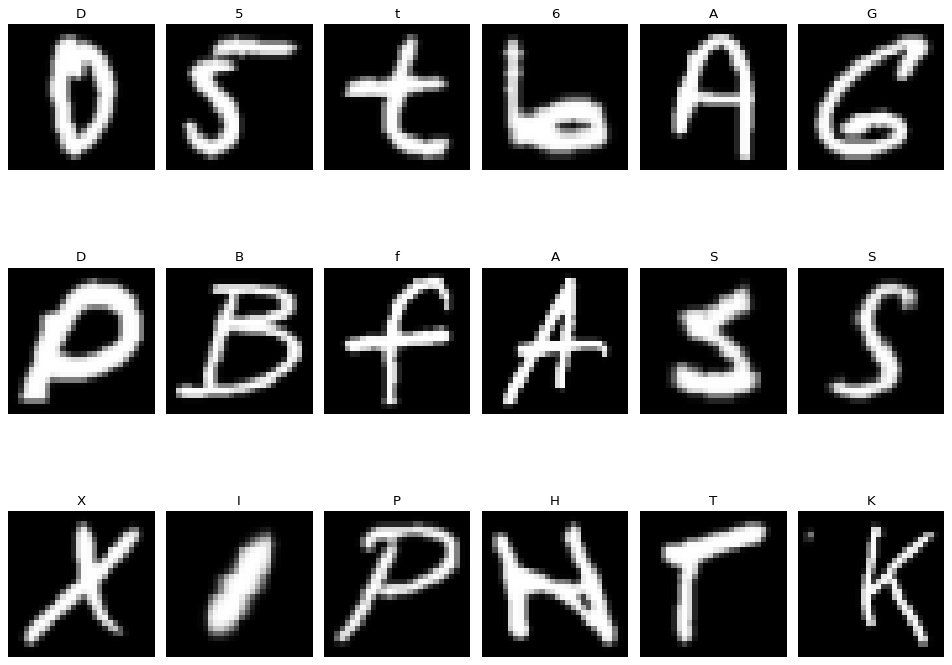

In [24]:
# Create label_dictionary from the mapping file (mapp)
label_dictionary = {index: chr(mapp.loc[index].values[0]) for index in mapp.index}

# Plot sample predictions
plt.figure(figsize=(12, 10), dpi=80)
for i in range(200, 218):
    plt.subplot(3, 6, i - 199)
    plt.imshow(test_x[i], cmap=plt.cm.gray)
    predicted_label = label_dictionary[y_pred_test[i].argmax()]
    plt.title(predicted_label)
    plt.axis('off')  # Hide axis for better visualization

plt.tight_layout()
plt.show()


In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the number of classes based on your EMNIST subset
number_of_classes = 47  # Adjust this based on your EMNIST subset

# Build the model
model = Sequential()

# First convolutional block
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(28, 28, 1), kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Second convolutional block
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

# Third convolutional block
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

# Fully connected layers
model.add(Flatten())
model.add(Dense(512, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

model.add(Dense(128, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(number_of_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train the model
history = model.fit(train_x, train_y, 
                    epochs=50, 
                    batch_size=128, 
                    validation_data=(val_x, val_y), 
                    callbacks=[early_stopping, reduce_lr])


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_16 (LeakyReLU)           │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_17 (LeakyReLU)           │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_18 (LeakyReLU)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,625,903 (6.20 MB)

 Trainable params: 1,623,727 (6.19 MB)

 Non-trainable params: 2,176 (8.50 KB)

Epoch 1/50
794/794 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.3770 - loss: 2.3570 - val_accuracy: 0.7867 - val_loss: 0.6530 - learning_rate: 0.0010
Epoch 2/50
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7541 - loss: 0.7644 - val_accuracy: 0.8463 - val_loss: 0.4242 - learning_rate: 0.0010
Epoch 3/50
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7987 - loss: 0.5990 - val_accuracy: 0.8613 - val_loss: 0.3784 - learning_rate: 0.0010
Epoch 4/50
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8221 - loss: 0.5324 - val_accuracy: 0.8656 - val_loss: 0.3660 - learning_rate: 0.0010
Epoch 5/50
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8357 - loss: 0.4953 - val_accuracy: 0.8715 - val_loss: 0.3487 - learning_rate: 0.0010
Epoch 6/50
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8404 - loss: 0.4698 - val_accuracy: 0.8782 - val_loss: 0.3283 - learning_rate: 0.0010
Epoch 7/50
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8515 - loss: 0.4394 